### INITIALIZATION

In [50]:
# Import external libraries:
import numpy as np
import skfem as sk
import matplotlib.pyplot as plt

# Import external functions:
from skfem.helpers import dot, grad
from scipy.sparse.linalg import splu
from skfem.visuals.matplotlib import plot

In [52]:
# Define problem size:
H = 200 # [cm] core length
L = 120 # [cm] heat-exchanger length

# Define region identifier:
reg_H = lambda x: (x>=0) * (x<H)    # Core region identifier
reg_L = lambda x: (x>=H) * (x<H+L)  # Heat-exchanger identifier

# Define problem parameters:
a_T_temp, a_H_temp, a_L_temp =  0.0, -0.1,  0.1  # Reaction parameters   [1/s]
b_T_temp, b_H_temp, b_L_temp =  0.5,  0.0,  0.0  # Diffusion parameters  [cm^2/s]
c_T_temp, c_H_temp, c_L_temp =  1.0,  0.0,  0.0  # Advection parameters  [cm/s]

# Define time discretization
dt = 0.0025         # Time step width [s]
time_steps = 40000  # Number of time steps [-]
theta = 0.00        # Define integration scheme: 0.0 -> implicit, 0.5 -> Crank-Nicolson, 1.0 -> explicit

# Define mesh discretization
poly_order = 2                 # Continuous Galerkin polinomial order
mesh_steps = 160               # Number of spatial mesh intervals [-]
mesh_width = (H+L)/mesh_steps  # Mesh element width [cm]
mash_nodes = np.linspace(0, H+L+mesh_width, mesh_steps+2)

### CONTINUOUS GALERKIN

#### Define problem bilinear forms

In [55]:
# Define global diffusion bilinear form for continuous Galerkin:
@sk.BilinearForm
def diffusion_cgi_T(u, v, _): return dot(grad(u), grad(v))

# Define advection bilinear form for continuous Galerkin:
@sk.BilinearForm
def advection_cgi_T(u, v, _): return grad(u)[0] * v

# Define mass bilinear form on the full domain:
@sk.BilinearForm 
def mass_cgi_T(u, v, _): return u * v

# Define mass bilinear form on the core region:
@sk.BilinearForm
def mass_cgi_H(u, v, w): return reg_H(w.x[0]) * u * v

# Define mass bilinear form on the heat-exchanger region:
@sk.BilinearForm
def mass_cgi_L(u, v, w): return reg_L(w.x[0]) * u * v

# Define forcing term for the initial condition:
@sk.LinearForm
def forcing_cgi_T(v, w): return v * (w.x[0]<35) * (w.x[0]>= 0) * (w.x[0]/35) - v * (w.x[0]<70) * (w.x[0]>=35) * (w.x[0]/35 - 2)

#### Define mathod to convert matrices defined on a simple domain to a periodic domain

In [59]:
# Define list of columns to keep in periodic domain configuration and reordering:
list_col = np.array(list(range(mesh_steps)) + list(range(mesh_steps+1, poly_order*mesh_steps+1)))
list_ord = np.hstack([[ii + jj*mesh_steps for jj in range(poly_order)] for ii in range(mesh_steps)])

# Convert continuous Galerkin matrix to periodic form:
def periodic_matrix_cg(matrix):
    matrix[:, 0] += matrix[:, mesh_steps]
    matrix[0, :] += matrix[mesh_steps, :]
    return matrix[list_col, :][:, list_col]

#### Assemble all the matrices and the vectors needed for the solution of a RAD problem:

In [61]:
# Define continuous Galerkin basis:
line_mesh_periodic_cg = sk.MeshLine(mash_nodes[:-1])
if poly_order==1 : line_element_cg = sk.element.ElementLineP1()
if poly_order==2 : line_element_cg = sk.element.ElementLineP2()
line_basis_cg = sk.Basis(line_mesh_periodic_cg, line_element_cg)

# Assemble reaction term matrices:
MM_T_1D_cg = periodic_matrix_cg(mass_cgi_T.assemble(line_basis_cg))
MM_H_1D_cg = periodic_matrix_cg(mass_cgi_H.assemble(line_basis_cg))
MM_L_1D_cg = periodic_matrix_cg(mass_cgi_L.assemble(line_basis_cg))

# Define advection and diffusion matrices:
KK_T_1D_cg = periodic_matrix_cg(diffusion_cgi_T.assemble(line_basis_cg))
CC_T_1D_cg = periodic_matrix_cg(advection_cgi_T.assemble(line_basis_cg))

# Define left and right hand side of the continuous Galerkin problem:
SS_all_cg = a_H_temp * MM_H_1D_cg + a_L_temp * MM_L_1D_cg + b_T_temp * KK_T_1D_cg + c_T_temp * CC_T_1D_cg
AA_all_cg = MM_T_1D_cg +      theta  * SS_all_cg * dt
BB_all_cg = MM_T_1D_cg - (1 - theta) * SS_all_cg * dt

# Define initial conditions:
f_cg = forcing_cgi_T.assemble(line_basis_cg)[list_col]
z_cg = sk.solve(KK_T_1D_cg + 0.001 * MM_T_1D_cg, f_cg)

#### Solve problem in time

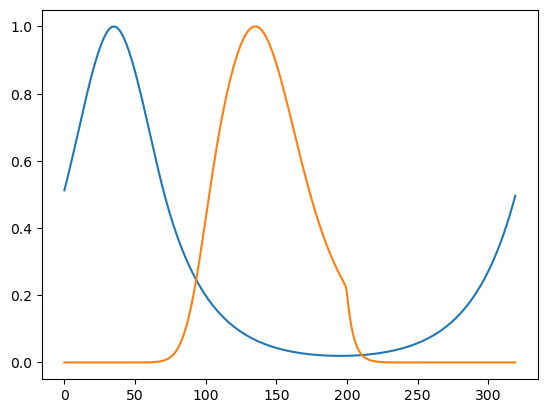

In [75]:
# Initialise solution nd-array:
solution_cg = np.ones((AA_all_cg.shape[0], time_steps+1))
solution_cg[:, 0] = z_cg

# Iteratively solve problem:
backsolve_cg = splu(AA_all_cg.T).solve
for ii in range(time_steps):
    solution_cg[:, ii+1] = backsolve_cg(BB_all_cg @ solution_cg[:, ii])

# Plot the solution at the initial and at the finial time:
plt.plot(solution_cg[list_ord,  0] / max(solution_cg[:,  0]))
plt.plot(solution_cg[list_ord, -1] / max(solution_cg[:, -1]))
plt.show()

#### I leave here a possible approach to implement online asseblage of linearised terms for nonlinear problems

In [ ]:
# Convert periodic vector into non-periodic original domain:
def vector_xx(vector): return np.hstack((vector[:mesh_steps], vector[0], vector[mesh_steps:]))

# Define non-linear interaction term for the reaction term:
def get_nl_mass_cgi_T(field):
    @sk.BilinearForm
    def nl_mass_cgi_T(u, v, _): return u * v * line_basis_cg.interpolate(vector_xx(field))
    return periodic_matrix_cg(nl_mass_cgi_T.assemble(line_basis_cg))

# Define non-linear interaction term for the diffusion term:
def get_nl_diffusion_cgi_T(field):  
    @sk.BilinearForm
    def nl_mass_cgi_T(u, v, _): return dot(grad(u), grad(v)) * line_basis_cg.interpolate(vector_xx(field))
    return periodic_matrix_cg(nl_mass_cgi_T.assemble(line_basis_cg))